In [1]:
dataset <- "SIRToscana"
state <- "Toscana"
match_dist <- 8000
new_dataset <- "TOS"

In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/plot.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/merging/analysis.R")
source("src/merging/display.R")
source("src/merging/combining.R")
source("src/merging/tagging.R")
source("notebooks/ds_regionali/procedure/common_steps.R")

conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state")


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



In [3]:
metadata <- query_checkpoint_meta(dataset, "qc1", conns$data) |>
    collect() |>
    arrange(dataset, sensor_key) |>
    mutate(key = row_number())
metadata_db <- copy_to(conns$data, metadata, "metas_tmp", overwrite = TRUE)

sensor_matches <- close_matches(metadata_db, match_dist, conns$stations)

data <- query_checkpoint_data(dataset, "qc1", conns$data) |>
    filter(valid) |>
    inner_join(metadata_db |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key")) |>
    select(!c(starts_with("qc_"), valid))

var_matches <- series_matches(data, sensor_matches, metadata_db)


In [4]:
analysis <- series_matches_analysis(var_matches, data, metadata_db, matches_offsets = c(-1L, 0L, 1L))
analysis |> write_xlsx_analysis(file.path("notebooks", "ds_regionali", state, "raw_analysis.xlsx"))


In [5]:
source(str_glue("notebooks/ds_regionali/{str_to_lower(state)}/procedures/match_taggers.R"))
tagged_analysis <- analysis |>
    tag_same_series() |>
    default_logic(TRUE) |>
    tag_manual()

write_xlsx_analysis(tagged_analysis, file.path("notebooks", "ds_regionali", state, "tagged_analysis.xlsx"), starts_with("tag_"))


In [8]:
gs <- series_groups(tagged_analysis, metadata, data, tag_same_series)
ranked_series_groups <- rank_series_groups(gs$table, metadata, c(dataset), desc(dataset), desc(sensor_last))
ignore_corrections <- NULL
incomp <- incompatible_merges(data, ranked_series_groups, tagged_analysis, 5L, 0.5, ignore_corrections)


In [9]:
i <- incomp |>
    left_join(metadata |> select(key, name, network, sensor_key), by = c("key_x" = "key")) |>
    left_join(metadata |> select(key, name, network, sensor_key), by = c("key_y" = "key"), suffix = c("_x", "_y")) |>
    arrange(desc(abs(k0 + 2 * k1 / pi)))
i


pkey,k0,k1,k2,k3,gkey,key_x,key_y,variable,offset_days,name_x,network_x,sensor_key_x,name_y,network_y,sensor_key_y
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>
10,0.7886081,0.5088734,0.1459423,0.009908382,5,61,317,1,0,Carrara,SIRT - Automatiche SIR,61,Carrara,SIRT - Tradizionali,317


In [10]:
merge_results <- dynamic_merge(data, ranked_series_groups, metadata, tagged_analysis, rejection_threshold = 10, ignore_corrections, contribution_threshold = 2L*365L)
merged_checkpoint(merge_results, metadata, new_dataset, conns$stations)
# rm(merge_results)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2079991,111.1,3526942,188.4,NA,3526942,188.4
Vcells,52238011,398.6,124844270,952.5,16384,124822008,952.4


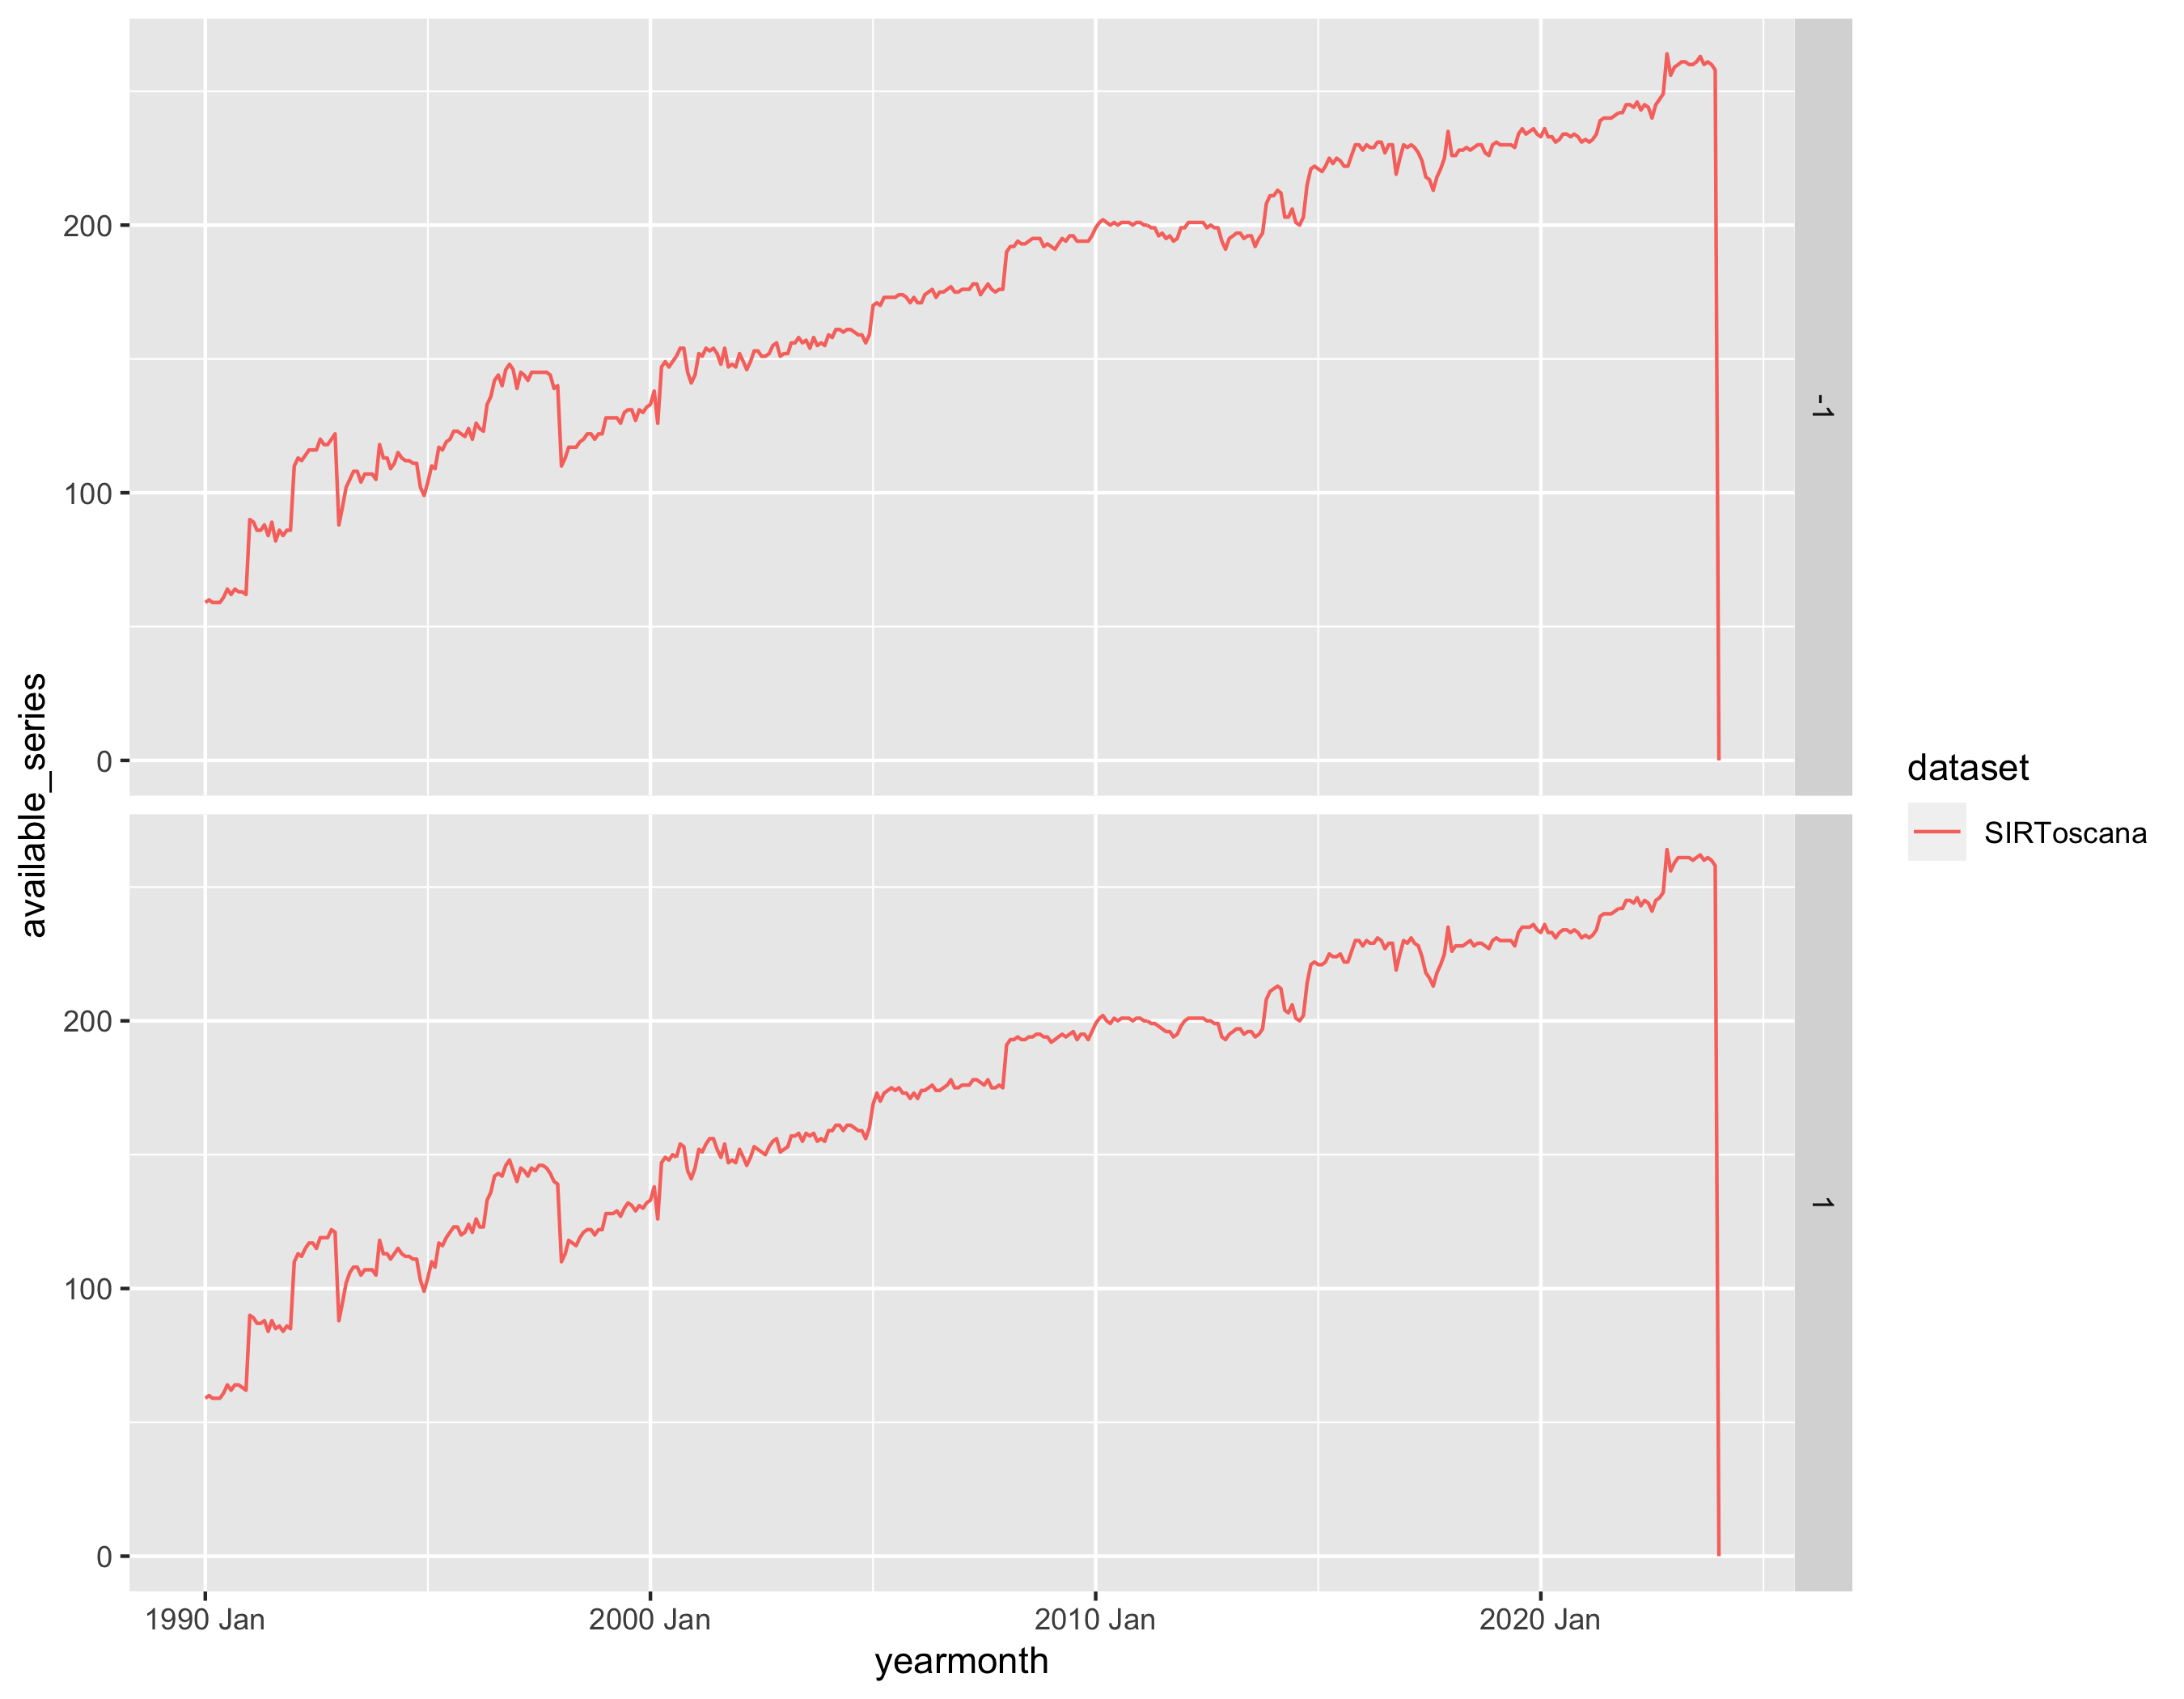

In [11]:
db <- query_checkpoint(new_dataset, "merged", conns$data, all_stations = FALSE)
mt <- db$meta |> select(sensor_key, from_datasets) |> collect() |> rowwise() |> mutate(dataset = paste0(from_datasets |> unique() |> sort(), collapse = ",")) |> ungroup() |> select(-from_datasets)
dt <- db$data |> select(-dataset) |> left_join(mt, by = "sensor_key", copy = TRUE) |> filter(year(date) >= 1990L)
pd <- ymonthly_availabilities(dt)
pd$plot + facet_grid(variable ~ .)

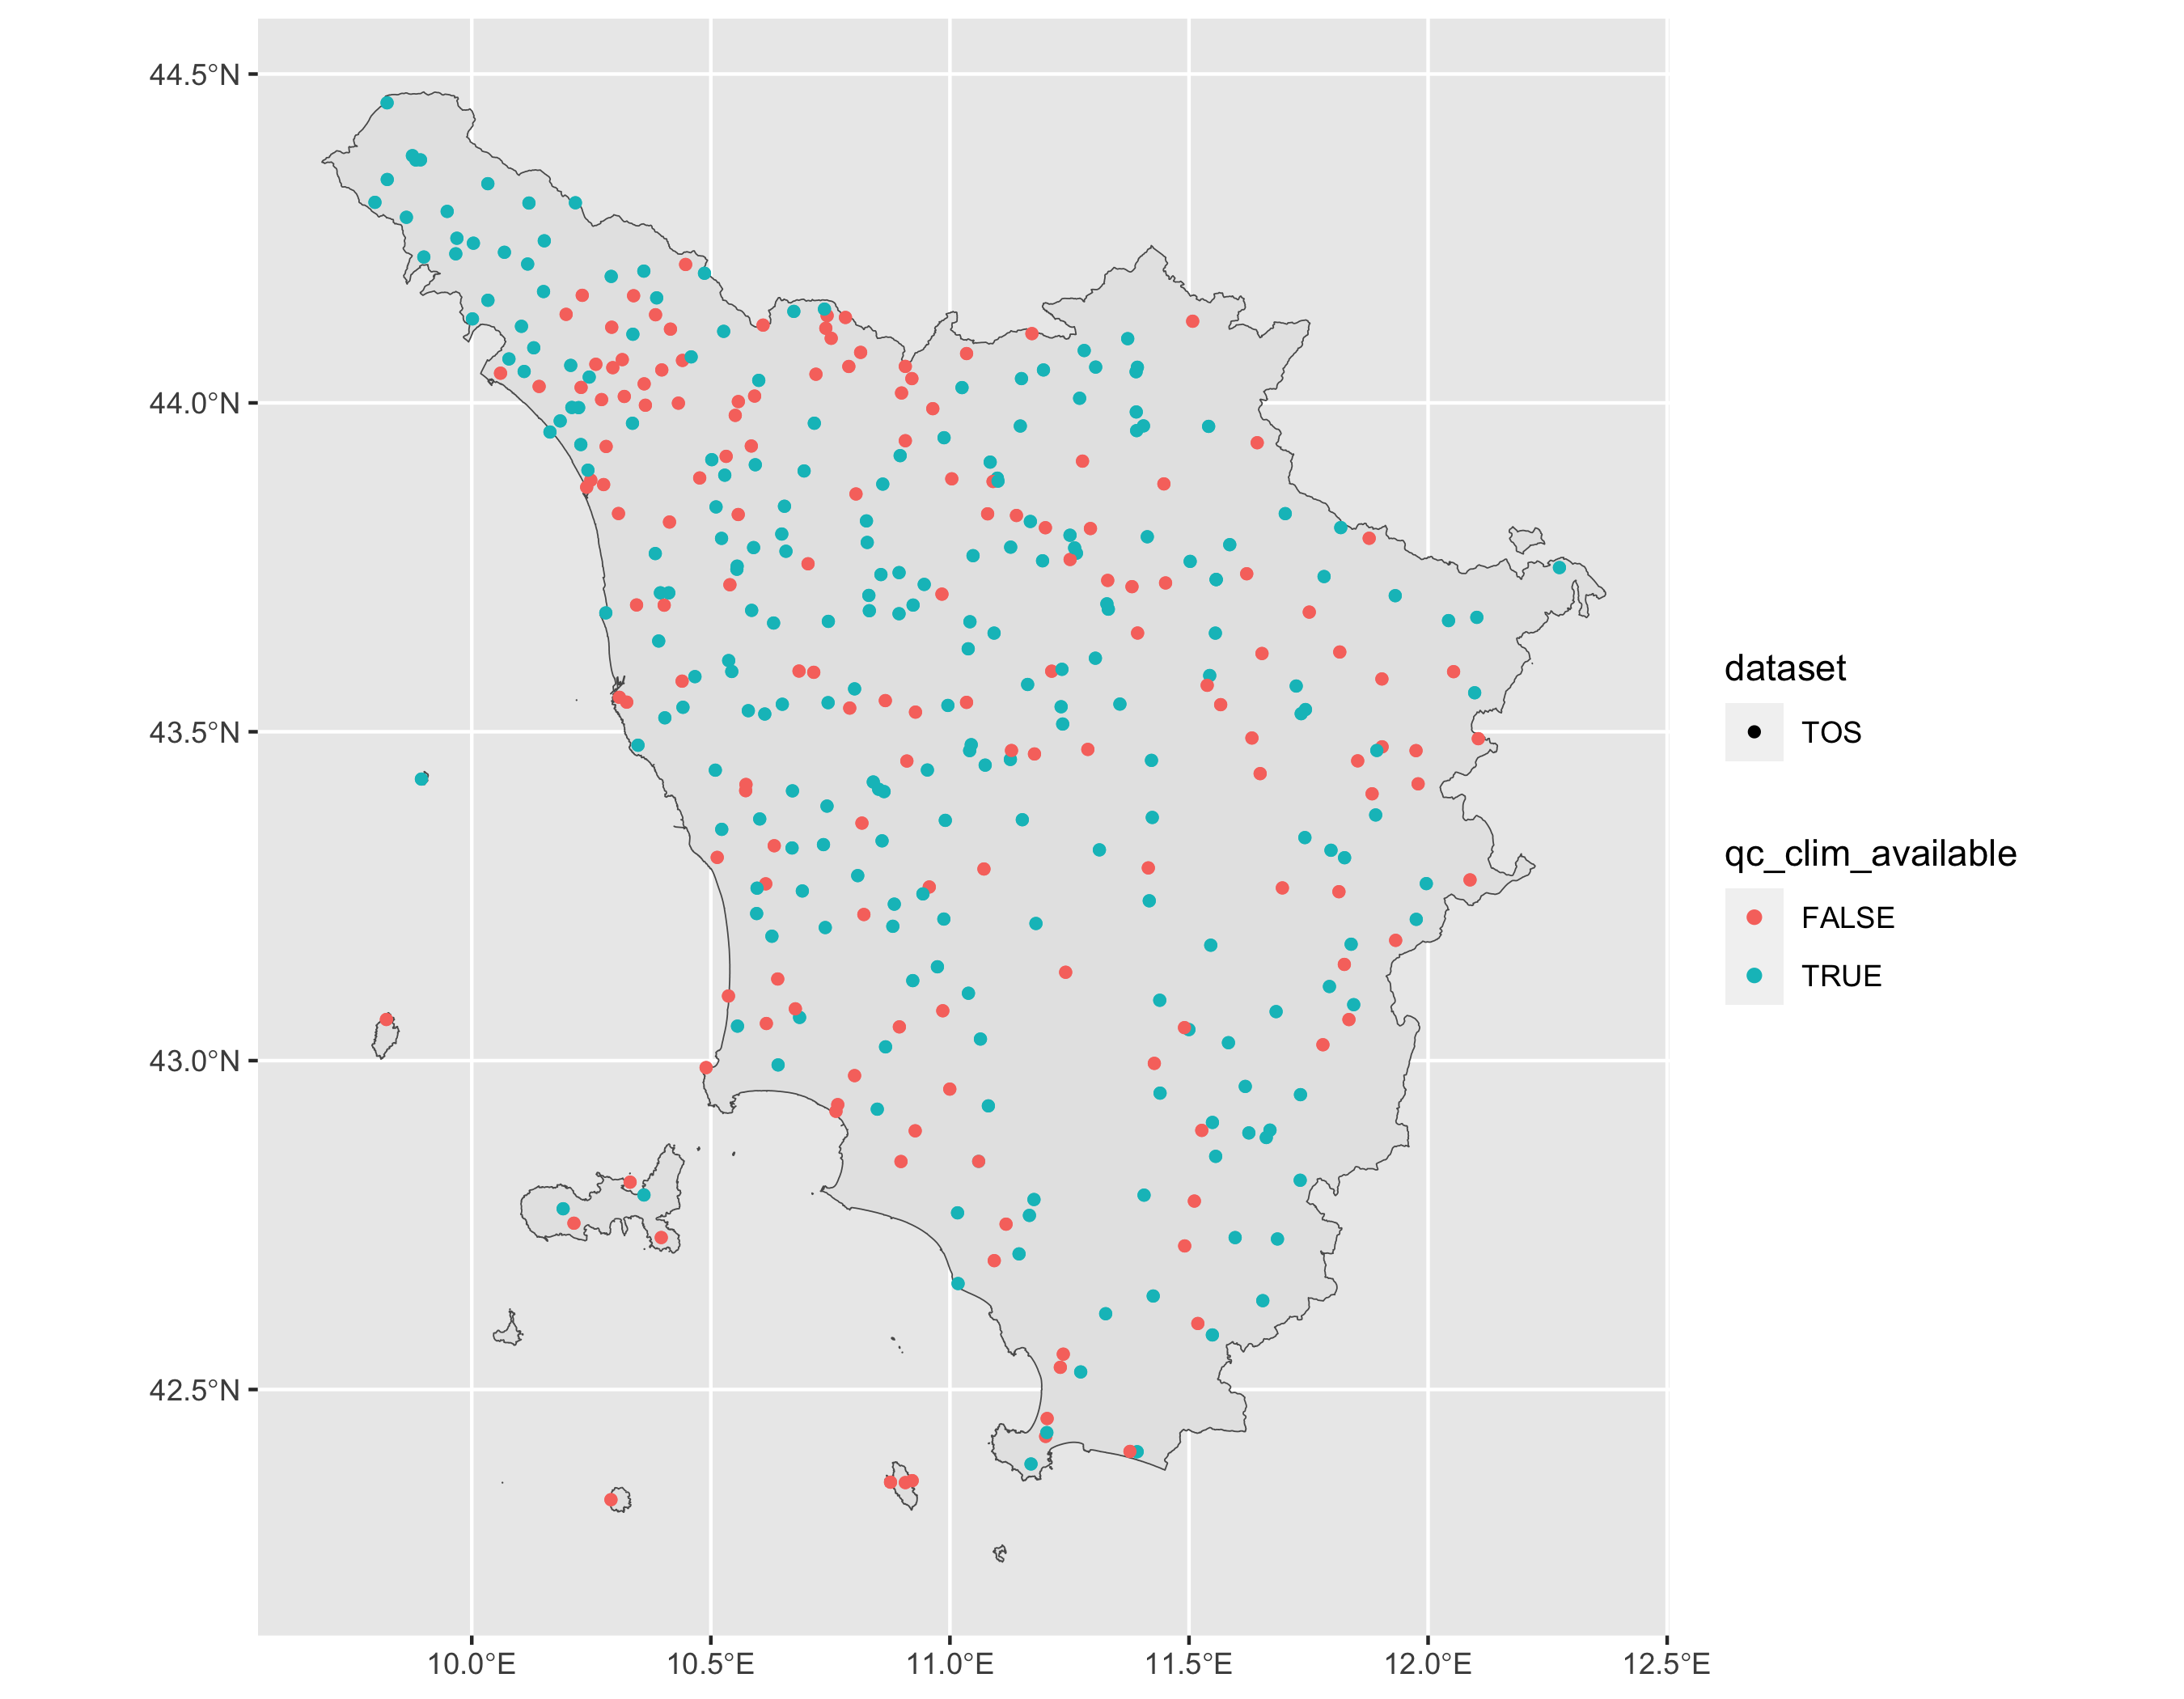

In [12]:
pd <- spatial_availabilities(pd$data |> mutate(dataset = new_dataset), db$meta, state_boundaries)
pd$plot

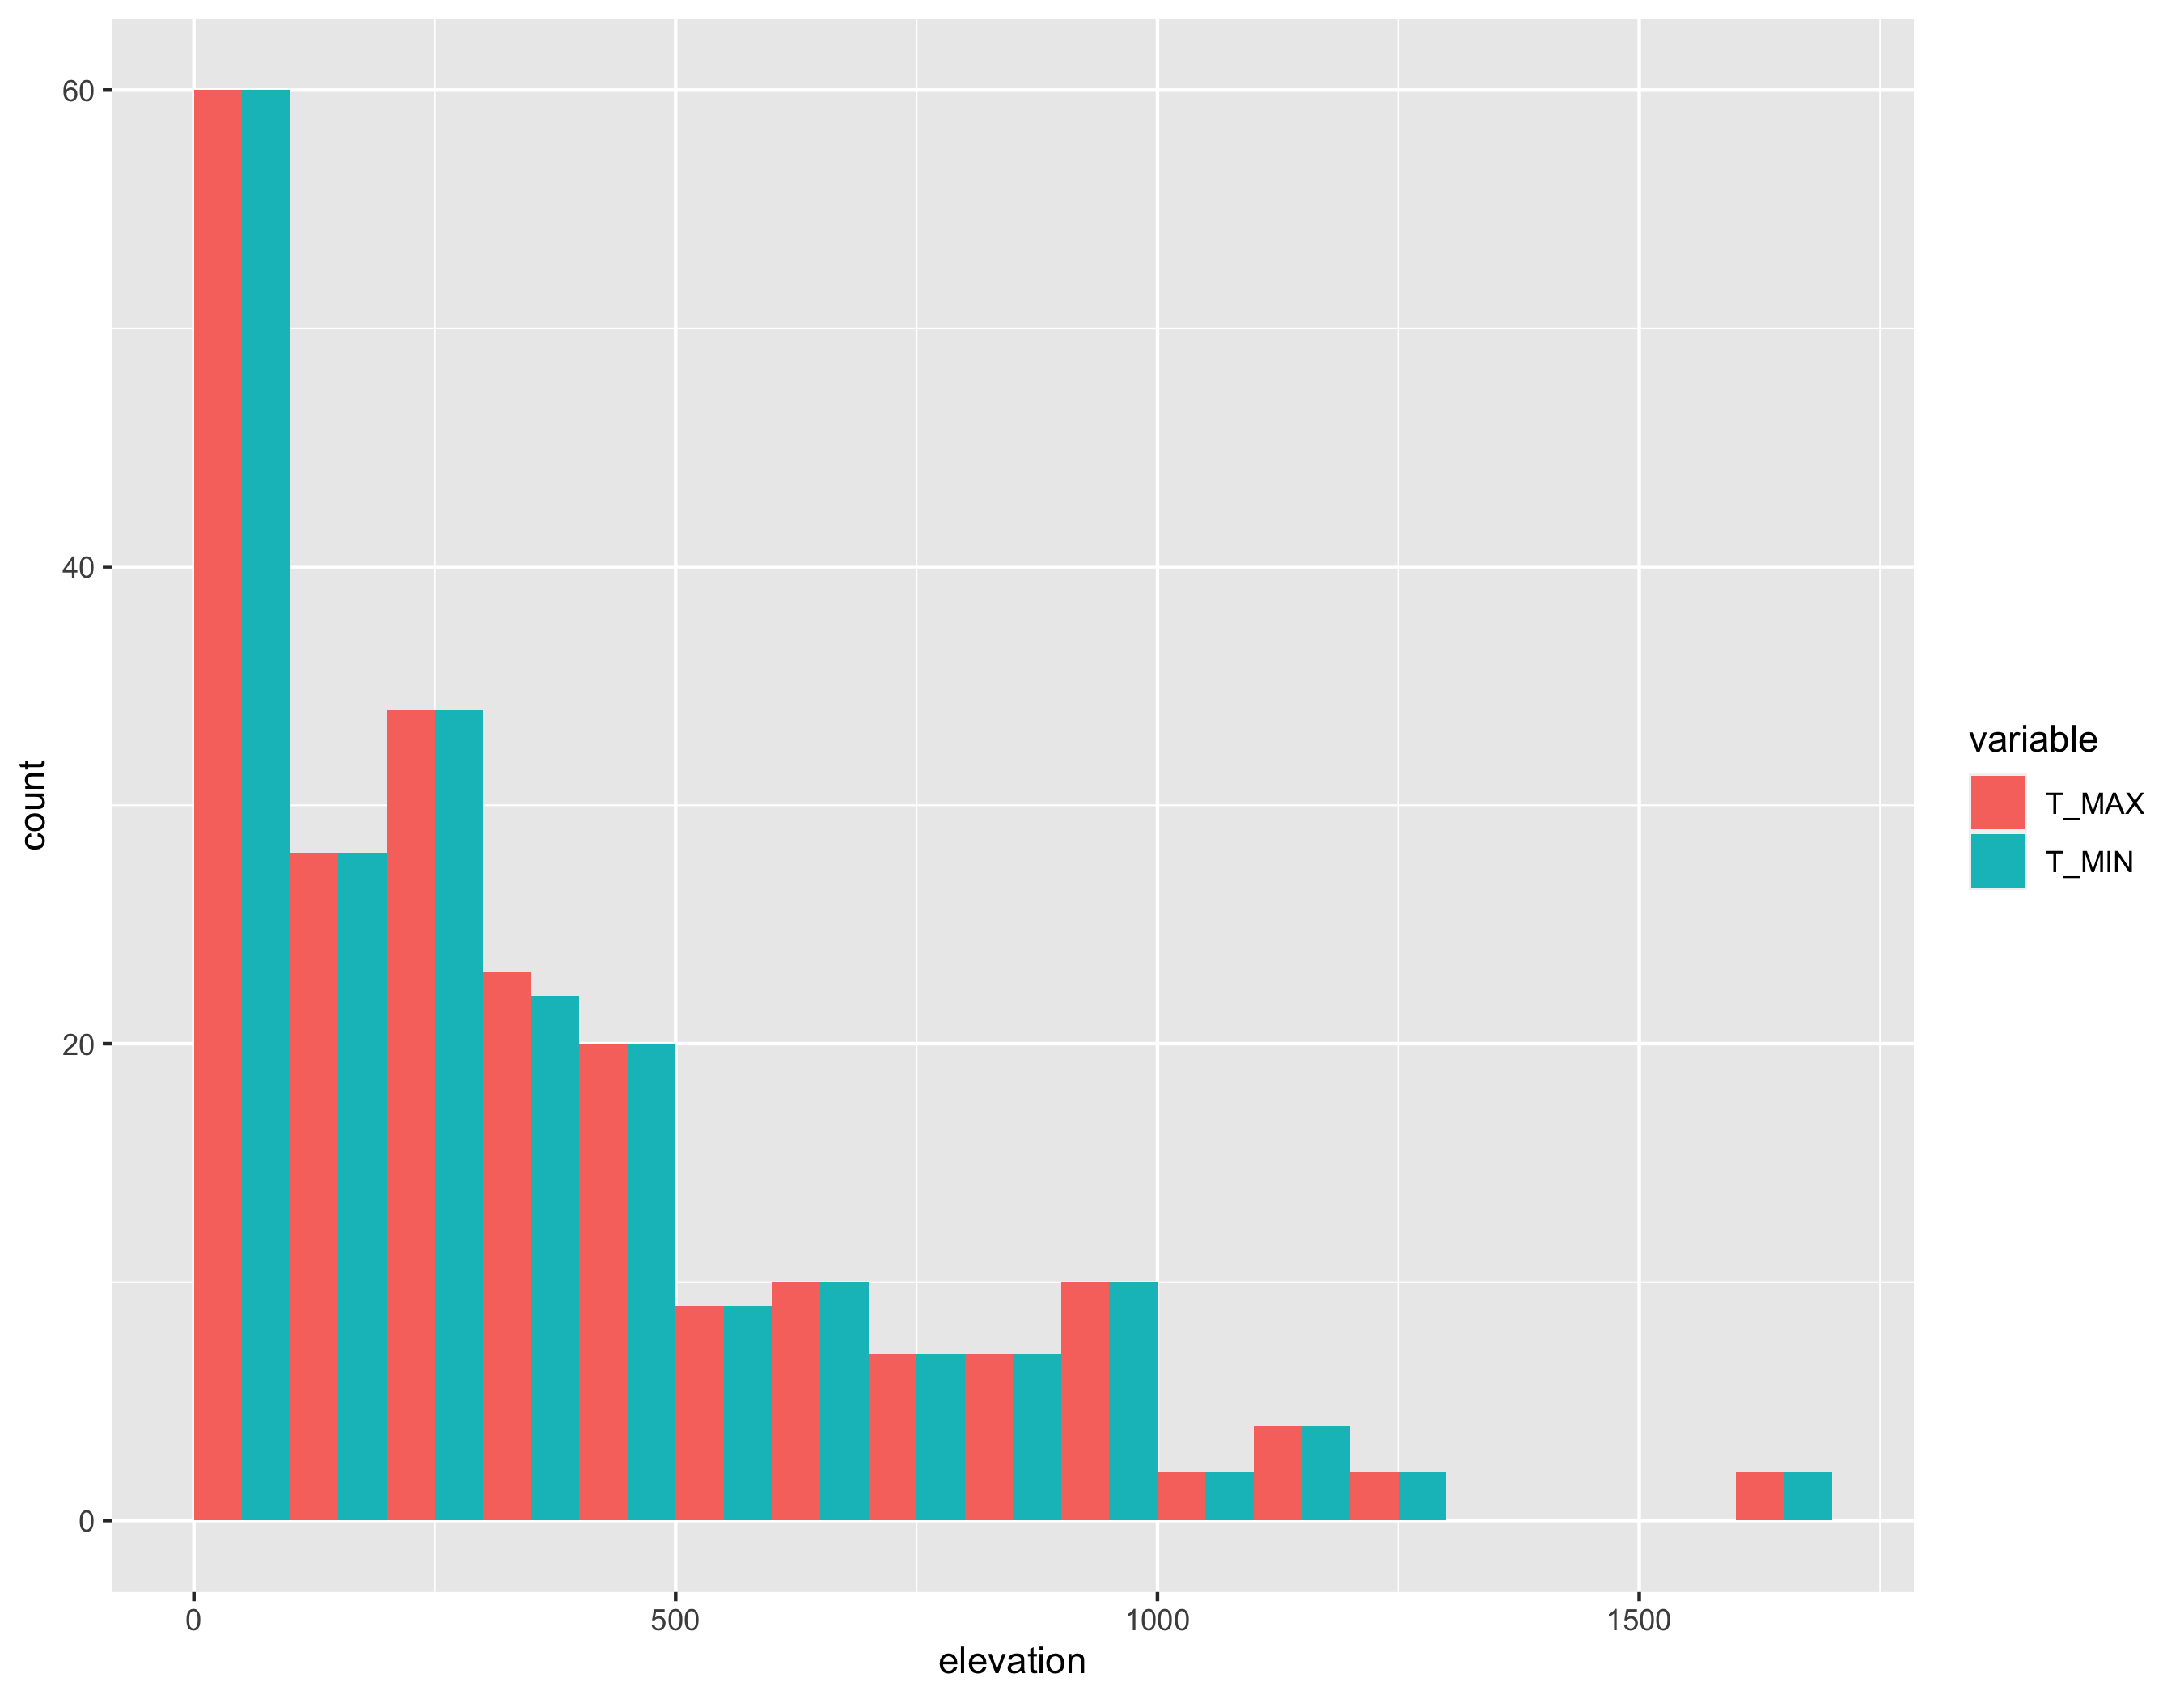

In [21]:
clim_availabilities <- pd$data |> mutate(dataset = new_dataset)
plot_available_by_elevation(clim_availabilities, db$meta |> collect())